# Understanding Probe at Position Results 
This document explores the data that the tp.data.query.probe_at_position() PyTecplot function returns through both a ordered and FE 2D data example.

Read on for more info...

## We'll start by creating some example ordered data

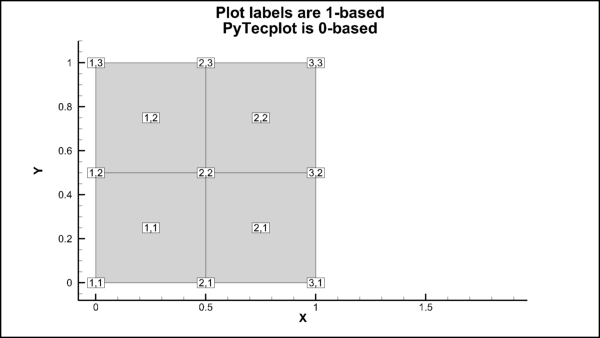

In [1]:
import tecplot as tp
from tecplot.constant import *
tp.new_layout()
tp.macro.execute_command('''$!CreateRectangularZone 
  IMax = 3
  JMax = 3
  KMax = 1
  X1 = 0
  Y1 = 0
  Z1 = 0
  X2 = 1
  Y2 = 1
  Z2 = 1
  XVar = 1
  YVar = 2''')
tp.active_frame().plot().show_mesh=True
tp.active_frame().plot().data_labels.show_node_labels=True
tp.active_frame().plot().data_labels.show_cell_labels=True
tp.active_frame().plot().axes.x_axis.min=-0.08
tp.active_frame().plot().axes.x_axis.max=1.2
tp.active_frame().plot().axes.y_axis.min=-0.08
tp.active_frame().plot().axes.y_axis.max=1.1
ds = tp.active_frame().dataset
tp.active_frame().add_text("Plot labels are 1-based\nPyTecplot is 0-based", position=(50,98), anchor=TextAnchor.HeadCenter, size=30)
tp.extension.ipython.show()

## Probe the cell at X=0.4, Y=0.8

In [2]:
res = tp.data.query.probe_at_position(0.4, 0.8, nearest=False, zones=[ds.zone(0)])
print(res)
print(res.data)
# Cell is a three valued tuple holding the 0-based IJK indices of the *cell* that was probed.
print(res.cell)
print("I:", res.cell[0])
print("J:", res.cell[1])
print(res.zone)

ProbeResult(data=[0.4, 0.8, 0.0], cell=(0, 1, 0), zone=Zone(uid=24, dataset=Dataset(uid=21, frame=Frame(uid=12, page=Page(uid=11)))))
[0.4, 0.8, 0.0]
(0, 1, 0)
I: 0
J: 1
Zone: 'Rectangular zone'
  Type: Ordered
  Shape: (3, 3, 1)


## Probe the nearest node to X=0.4, Y=0.8

In [3]:
res = tp.data.query.probe_at_position(0.4, 0.8, nearest=True, zones=[ds.zone(0)])
print(res)
print(res.data)
# Cell is a three valued tuple holding the 0-based IJK indices of the *node* that was probed.
print(res.cell)
print("I:", res.cell[0])
print("J:", res.cell[1])
print(res.zone)

ProbeResult(data=[0.4, 0.8, 0.0], cell=(1, 2, 0), zone=Zone(uid=24, dataset=Dataset(uid=21, frame=Frame(uid=12, page=Page(uid=11)))))
[0.4, 0.8, 0.0]
(1, 2, 0)
I: 1
J: 2
Zone: 'Rectangular zone'
  Type: Ordered
  Shape: (3, 3, 1)


# Probe at Position with Unstructured Data

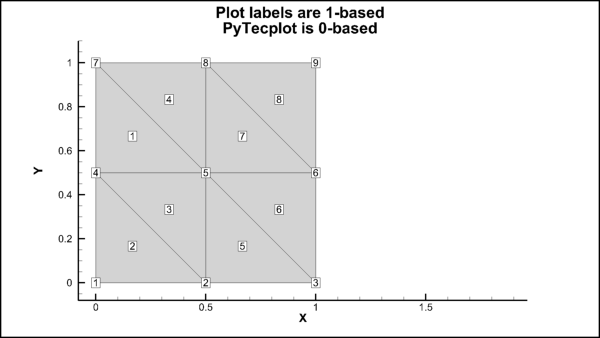

In [4]:
tp.macro.execute_command('''$!Triangulate 
  SourceZones =  [1]
  BoundaryZones =  []
  UseBoundary = No
  IncludeBoundaryPts = No
  TriangleKeepFactor = 0.25''')
# Hide the ordered zone
tp.active_frame().plot().fieldmap(ds.zone(0)).show = False
tp.extension.ipython.show()

## Probe the cell at X=0.4, Y=0.8
When probing a finite element cell (nearest=False) the node index should be ignored

In [5]:
res = tp.data.query.probe_at_position(0.4, 0.8, nearest=False, zones=[ds.zone(1)])
print(res)
print(res.data)
# Cell is a three valued tuple of Node Index, Cell Index, Ignore
print(res.cell)
print("Node Index:", res.cell[0], "<--Ignore this value, since we probed the cell")
print("Cell Index:", res.cell[1])
print(res.zone)

ProbeResult(data=[0.4, 0.8, 0.0], cell=(1438326694160, 3, -1), zone=Zone(uid=32, dataset=Dataset(uid=21, frame=Frame(uid=12, page=Page(uid=11)))))
[0.4, 0.8, 0.0]
(1438326694160, 3, -1)
Node Index: 1438326694160 <--Ignore this value, since we probed the cell
Cell Index: 3
Zone: 'Triangulation'
  Type: FETriangle
  Shape: (9, 8, 3)


## Probe the nearest node to X=0.4, Y=0.8
When probing a finite element node (nearest=True) the node index is the node nearest the probed point, while the cell index is the cell at the supplied XY[Z] location

In [6]:
#adding a Pressure variable
tp.data.operate.execute_equation('{Pressure} = {X} + {Y}', value_location=ValueLocation.CellCentered)
res = tp.data.query.probe_at_position(0.4, 0.8, nearest=True, zones=[ds.zone(1)])
print(res)
print(res.data)
# Cell is a three valued tuple of Node Index, Cell Index, Ignore
print(res.cell)
print("Node Index:", res.cell[0])
print("Cell Index:", res.cell[1])
print(res.zone)

ProbeResult(data=[0.4, 0.8, 1.3888888359069824], cell=(7, 3, -1), zone=Zone(uid=32, dataset=Dataset(uid=21, frame=Frame(uid=12, page=Page(uid=11)))))
[0.4, 0.8, 1.3888888359069824]
(7, 3, -1)
Node Index: 7
Cell Index: 3
Zone: 'Triangulation'
  Type: FETriangle
  Shape: (9, 8, 3)


### How do you retrieve a specific variable value at a probed location

In [7]:
var_index = ds.variable("Pressure").index
probed_pressure_value = res.data[var_index]
print(probed_pressure_value)

1.3888888359069824


### Cell Centered variable value for FE data:

In [8]:
cell_num = res.cell[1]
res_zone_name = res.zone
ds.variable("Pressure").values(res_zone_name)[cell_num]

1.1666666269302368

### Cell Centered variable value for Ordered data:

In [9]:
import ordered_cell_index as oci #see this script in GitHub

res = tp.data.query.probe_at_position(0.4, 0.8, nearest=True, zones=[ds.zone(0)]) #probing the ordered data
i,j,k = res.cell
cell_num = oci.cell_index(res.zone, i, j, k) #See the cell_index() function in the StructuredDataCellCentered.ipynb
ds.variable("Pressure").values(res_zone_name)[cell_num]

1.6666666269302368